# EDA PRM800K Dataset

In [118]:
# Setup and Imports
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as scp
# import plotly.express as px
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit

## Load Datasets

In [119]:
prm800k_test = pd.read_csv("dataset/prm800k-test.csv")
prm800k_test

,labeler,timestamp,generation,is_quality_control_question,is_initial_screening_question,question,label
0,e90a38f3-3135-4465-87af-3e6322e3d772,2022-07-30T23:23:32.118856,NaN,False,False,{'problem': 'Three pencils and a jumbo eraser ...,"{'steps': [{'completions': [{'text': ""Let's ca..."
1,debabc6d-f79c-4ee5-a9db-5e284390254c,2022-07-28T21:11:38.359626,NaN,False,False,"{'problem': 'Steve says to Jon, ""I am thinking...","{'steps': [{'completions': [{'text': ""Hey, you..."
2,debabc6d-f79c-4ee5-a9db-5e284390254c,2022-07-28T21:14:58.004130,NaN,False,False,{'problem': 'Compute $58_9 - 18_9.$ Express yo...,{'steps': [{'completions': [{'text': 'I think ...
3,e90a38f3-3135-4465-87af-3e6322e3d772,2022-07-30T23:38:08.623029,NaN,False,False,{'problem': 'What is $\\sqrt{53}$ in simplest ...,"{'steps': [{'completions': [{'text': ""Let's fi..."
4,e90a38f3-3135-4465-87af-3e6322e3d772,2022-07-31T01:42:39.680550,NaN,False,False,{'problem': 'What is the sum of all of the mul...,{'steps': [{'completions': [{'text': 'I think ...
...,...,...,...,...,...,...,...
2863,423ec391-7def-48bd-821a-5e231333d6ce,2022-11-10T21:59:40.659723,6.0,False,False,{'problem': 'What is the integer value of $x$ ...,{'steps': [{'completions': [{'text': 'An arith...
2864,30f0b980-2587-4ec3-957a-0ca2bf958c40,2022-11-10T21:59:39.648690,6.0,False,False,{'problem': 'The binary number $10101001110_{2...,{'steps': [{'completions': [{'text': 'To conve...
2865,909003eb-d16e-49c8-82ce-7664180c66b8,2022-11-10T21:59:14.778080,6.0,False,False,{'problem': 'The binary number $10101001110_{2...,{'steps': [{'completions': [{'text': 'I know t...
2866,a2e09d3a-2da6-4094-89ca-e92125f6aefd,2022-11-10T21:58:33.614002,6.0,False,False,{'problem': 'Simplify $\\frac{(10r^3)(4r^6)}{8...,{'steps': [{'completions': [{'text': 'To simpl...


## PRM800K Fields

| Column                          | Data Type       | Description                                                                                                                                                              |
| ------------------------------- | --------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| `labeler`                       | `str` (UUID)    | Unique identifier of the annotator or system that labeled the reasoning steps.                                                                                           |
| `timestamp`                     | `datetime`      | Timestamp indicating when the reasoning or labeling was performed. Useful for batch or temporal analysis.                                                                |
| `generation`                    | `str` or `null` | (Optional) May contain the ID of the generative model that produced the reasoning steps. Can be `null` for human-generated responses.                                    |
| `is_quality_control_question`   | `bool`          | `True` if the question is used for quality control purposes, e.g., testing annotator reliability.                                                                        |
| `is_initial_screening_question` | `bool`          | `True` if the question was used for screening labelers before they start actual annotation tasks.                                                                        |
| `question`                      | `dict`          | Contains the main question data, typically with keys:<br>• `problem`: the math problem in LaTeX or plain text<br>• `ground_truth_answer`: the correct answer as a string |
| `label`                         | `dict`          | Holds reasoning steps and associated labels. This includes a list of reasoning `steps`, each with several completions and possibly human feedback.                       |

The label['steps'] field contains a list of reasoning steps. Each step follows this structure:
```
{
  "completions": [
    {
      "text": "Some reasoning text...",
      "rating": 1,
      "flagged": false
    },
    ...
  ],
  "human_completion": {
    "text": "Manual correction or insight",
    "source": "human",
    "corrected_rating": null,
    "flagged": false
  },
  "chosen_completion": 2
}
```
Fields Explained
- completions: Multiple reasoning candidates for a given step.
- text: The reasoning text generated by a model or human.
- rating: Quality label of the reasoning:
```
1: correct
0: redundant
-1: incorrect
```
- flagged: Boolean indicating problematic or inappropriate completions.
- chosen_completion: Index of the preferred or accepted completion for the step.
- human_completion (optional): Manual input by a human evaluator to correct or guide the reasoning.

## Feature Engineering for PRM800K

Due to the lack of visibility caused by the deeply nested JSON format in the label column, especially the steps field. I have added several new columns to make exploration and analysis of PRM800K easier.

| **Column**                         | **Description**                                                                                                                                     |
|-----------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------|
| **`total_steps`**                 | Total number of reasoning steps per question.                                                                                                       |
| **`total_steps_have_neg_1`**      | Total number of steps that include at least one completion rated **-1** (indicating incorrect or misleading reasoning).                           |
| **`steps_neg_1`**                 | List of step indices (e.g., `[1, 2, 3, 4]`) where at least one completion has a rating of **-1**.                                                  |
| **`total_neg_1_sequence_from_last_step`** | Number of consecutive steps (counting backward from the last step) that contain at least one **-1** rating. Useful for analyzing late degradation. |
| **`total_steps_have_zero`**       | Total number of steps that include at least one completion rated **0** (neutral or uninformative reasoning).                                       |
| **`steps_zero`**                  | List of step indices where at least one completion has a rating of **0**.                                                                          |
| **`total_steps_have_pos_1_or_human`**      | Total number of steps that include at least one completion rated **1** (good or helpful reasoning) or human completion.                                                |
| **`steps_pos_1_or_human`**                 | List of step indices where at least one completion has a rating of **1** or human completion.                                                                          |
| **`total_steps_have_combination`**| Total number of steps that contain **all three types of ratings**: **-1**, **0**, and **1/human**. Helps identify steps with diverse or conflicting judgment. |
| **`finish_reason`**               | Original `finish_reason` field from the dataset, indicating how the reasoning process was concluded (e.g., `"solution"`, `"give_up"`).             |

### String to Dict (Convert JSON)

In [120]:
import json
import ast

def string_to_dict(input_string):
    input_string = input_string.strip()

    try:
        json_string = input_string.replace("'", '"')
        json_string = json_string.replace('True', 'true').replace('False', 'false').replace('None', 'null')
        return json.loads(json_string)
    except (json.JSONDecodeError, ValueError):
        pass
    
    try:
        return ast.literal_eval(input_string)
    except (ValueError, SyntaxError):
        pass
    
    try:
        if input_string.strip().startswith('{') and input_string.strip().endswith('}'):
            return eval(input_string)
    except:
        pass

    raise ValueError(f"Cannot parse string as dictionary: {input_string[:100]}...")

### Check Rating Completion

In [121]:
def get_step_info(step):    
    neg_1 = 0
    zero = 0
    pos_1 = 0
    
    for idx, completion in enumerate(step['completions']):
        rating = completion['rating']
        if rating == -1:
            neg_1 += 1
        elif rating == 0:
            zero += 1
        elif rating == 1:
            pos_1 += 1

    human_completion = step['human_completion']

    rating_info = {
        "-1": neg_1,
        "0": zero,
        "1": pos_1,
        "human_completion": human_completion        
    }
    
    return rating_info

### Rating Breakdown

In [122]:
# Input:
"""
[
  {"-1": 1, "0": 1, "1": 1, "human_completion": null},
  {"-1": 1, "0": 1, "1": 1, "human_completion": null},
  {"-1": 1, "0": 0, "1": 0, "human_completion": {
      "text": "No, it shouldn't. The leading term of the product is the product of the leading terms of the factors, and the degree is the sum of the degrees.",
      "rating": null,
      "source": "human",
      "flagged": false,
      "corrected_rating": null
  }},
  {"-1": 0, "0": 0, "1": 1, "human_completion": null},
  {"-1": 1, "0": 0, "1": 1, "human_completion": null},
  {"-1": 0, "0": 0, "1": 1, "human_completion": null},
  {"-1": 1, "0": 1, "1": 1, "human_completion": null}
]
"""

def rating_breakdown(rating_infos):
    steps_neg_1 = []
    total_neg_1_sequence_from_last_step = 0
    steps_zero = []
    steps_pos_1_or_human = []
    total_steps_have_combination = 0
    
    counter = 1
    for step in rating_infos:
        is_neg_1 = step["-1"] > 0
        is_zero = step["0"] > 0
        is_pos_1 = step["1"] > 0 or step["human_completion"] is not None

        if is_neg_1:
            steps_neg_1.append(counter)
        if is_zero:
            steps_zero.append(counter)
        if is_pos_1:
            steps_pos_1_or_human.append(counter)
        if is_neg_1 and is_zero and is_pos_1:
            total_steps_have_combination += 1

        counter += 1
    
    reversed_steps_neg_1 = steps_neg_1[::-1]
    if reversed_steps_neg_1 and reversed_steps_neg_1[0] == len(rating_infos):
        pivot = len(rating_infos)
        for step in reversed_steps_neg_1:
            if step == pivot:
                total_neg_1_sequence_from_last_step += 1
            else:
                break
            pivot -= 1
            
    result = {
        "total_steps_have_neg_1": len(steps_neg_1),
        "steps_neg_1": steps_neg_1,
        "total_neg_1_sequence_from_last_step": total_neg_1_sequence_from_last_step,
        "total_steps_have_zero": len(steps_zero),
        "steps_zero": steps_zero,
        "total_steps_have_pos_1_or_human": len(steps_pos_1_or_human),
        "steps_pos_1_or_human": steps_pos_1_or_human,
        "total_steps_have_combination": total_steps_have_combination
    }

    return result

### Process PRM800K Data

In [123]:
def feature_engineering(prm800k_train):
    results = []
    
    for index, row in prm800k_train.iterrows():
        try:
            data = string_to_dict(row['label'])
            finish_reason = data['finish_reason']
            rating_infos = []
            
            # Process each step
            for step_no, step in enumerate(data['steps']):
                rating_info = get_step_info(step)
                rating_infos.append(rating_info)

            result = rating_breakdown(rating_infos)
            new_result = {
                **row.to_dict(),
                "total_steps": len(rating_infos),
                **result,
                "finish_reason": finish_reason,
            }
            results.append(new_result)
        
        except Exception as e:
            print(f"Error processing row {index}: {e}")
            continue
    
    # Create DataFrame from results
    results_df = pd.DataFrame(results)
    return results_df

### Run Feature Engineering

In [124]:
df_feature_engineered = feature_engineering(prm800k_test)
df_feature_engineered = df_feature_engineered.sort_values('total_steps_have_combination', ascending=False)
df_feature_engineered.to_csv('dataset/prm800k-test-feature-engineered.csv', index=False)

Error processing row 100: 'NoneType' object is not iterable


In [125]:
df_feature_engineered

,labeler,timestamp,generation,is_quality_control_question,is_initial_screening_question,question,label,total_steps,total_steps_have_neg_1,steps_neg_1,total_neg_1_sequence_from_last_step,total_steps_have_zero,steps_zero,total_steps_have_pos_1_or_human,steps_pos_1_or_human,total_steps_have_combination,finish_reason
62,debabc6d-f79c-4ee5-a9db-5e284390254c,2022-07-30T14:37:13.296218,NaN,False,False,{'problem': 'There are an infinite number of v...,"{'steps': [{'completions': [{'text': ""Let's se...",34,22,"[2, 3, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...",3,14,"[2, 3, 4, 6, 7, 9, 11, 13, 18, 20, 24, 26, 27,...",34,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",11,solution
56,debabc6d-f79c-4ee5-a9db-5e284390254c,2022-07-30T13:26:58.414691,NaN,False,False,{'problem': 'When rolling a certain unfair six...,"{'steps': [{'completions': [{'text': ""Well, le...",35,18,"[2, 3, 4, 6, 8, 9, 12, 13, 14, 17, 18, 19, 20,...",0,11,"[3, 4, 8, 9, 12, 13, 15, 18, 21, 28, 31]",35,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",10,solution
1,debabc6d-f79c-4ee5-a9db-5e284390254c,2022-07-28T21:11:38.359626,NaN,False,False,"{'problem': 'Steve says to Jon, ""I am thinking...","{'steps': [{'completions': [{'text': ""Hey, you...",30,12,"[6, 7, 11, 15, 19, 20, 22, 23, 25, 26, 27, 28]",0,9,"[2, 6, 8, 15, 20, 22, 23, 25, 27]",29,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",7,give_up
16,debabc6d-f79c-4ee5-a9db-5e284390254c,2022-07-31T14:39:30.588403,NaN,False,False,{'problem': 'Find all solutions to\n\\[\\sin \...,"{'steps': [{'completions': [{'text': ""Let's us...",34,13,"[1, 2, 6, 7, 8, 14, 16, 18, 29, 30, 31, 32, 34]",1,7,"[2, 7, 8, 14, 16, 33, 34]",34,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",6,solution
8,debabc6d-f79c-4ee5-a9db-5e284390254c,2022-07-29T07:48:01.714041,NaN,False,False,{'problem': 'The solutions of the equation $z^...,{'steps': [{'completions': [{'text': 'There is...,40,17,"[2, 6, 8, 9, 11, 12, 16, 17, 18, 20, 25, 30, 3...",0,8,"[2, 3, 16, 17, 18, 20, 30, 40]",40,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",6,solution
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,215edb5c-9e68-4edb-8702-5a23153c45b5,2022-11-11T22:06:30.366511,6.0,False,False,"{'problem': 'The proper divisors of 12 are 1, ...",{'steps': [{'completions': [{'text': 'To find ...,24,1,[24],1,1,[2],23,"[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",0,found_error
1076,b5b0d9b5-90f0-4756-ab90-140836ed55ab,2022-11-11T22:05:57.635928,6.0,False,False,{'problem': 'What is the largest integer less ...,{'steps': [{'completions': [{'text': 'I want t...,3,1,[3],1,0,[],2,"[1, 2]",0,found_error
1077,3ab03791-a582-40fc-8451-9a584f94f8ec,2022-11-11T22:03:08.035236,6.0,False,False,"{'problem': 'For some value of $x,$ $0 < x < 1...",{'steps': [{'completions': [{'text': 'This loo...,9,1,[9],1,2,"[5, 9]",7,"[1, 2, 3, 4, 6, 7, 8]",0,found_error
1078,36a22309-0e20-451c-8aaa-0d90d8e9410a,2022-11-11T22:02:43.945355,6.0,False,False,{'problem': 'What is the largest integer less ...,{'steps': [{'completions': [{'text': 'I need t...,8,1,[8],1,1,[6],6,"[1, 2, 3, 4, 5, 7]",0,found_error


## EDA Functions

### 1. Get Total Steps

In [126]:
def get_total_steps_sum(df):
    return df['total_steps'].sum()

### 2. Get Finish Reason Counts

In [127]:
def get_finish_reason_counts(df):
    return df['finish_reason'].value_counts().to_dict()

### 3. Filter Only "solution" Rows (Get Valid Data)

In [128]:
def filter_solution_finish_reason(df):
    return df[df['finish_reason'] == 'solution']

### 4. Filter Rows Where Positive Exist on All Steps (Get Valid Data)

In [129]:
def filter_all_steps_exist_pos_or_human(df):
    return df[df['total_steps'] == df['total_steps_have_pos_1_or_human']]

### 5. Total Steps Distribution

In [130]:
import matplotlib.pyplot as plt

def plot_total_steps_distribution(df):
    dist = df['total_steps'].value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    plt.bar(dist.index, dist.values, color="#4C72B0", edgecolor="black")
    
    plt.title("Distribution of total_steps", fontsize=14)
    plt.xlabel("Total Steps", fontsize=12)
    plt.ylabel("Number of Rows", fontsize=12)
    plt.xticks(dist.index)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

### 6. Negative Steps Position Distribution

In [131]:
import matplotlib.pyplot as plt
from collections import Counter
import ast

def plot_negative_steps_tertile_distribution(df):
    tertile_counter = Counter({"T1": 0, "T2": 0, "T3": 0})

    for _, row in df.iterrows():
        try:
            steps = row['steps_neg_1']
            total_steps = row['total_steps']

            if isinstance(steps, str):
                steps = ast.literal_eval(steps)
            if not isinstance(steps, list) or total_steps == 0:
                continue

            for step in steps:
                percent_pos = (step / total_steps) * 100
                if percent_pos <= 33:
                    tertile_counter["T1"] += 1
                elif percent_pos <= 66:
                    tertile_counter["T2"] += 1
                else:
                    tertile_counter["T3"] += 1

        except Exception as e:
            print(f"Error processing row: {e}")
            continue

    # Prepare data for plotting
    tertile_labels = ["T1 (0–33%)", "T2 (34–66%)", "T3 (67–100%)"]
    counts = [tertile_counter["T1"], tertile_counter["T2"], tertile_counter["T3"]]

    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(tertile_labels, counts, color=["#1f77b4", "#ff7f0e", "#2ca02c"], edgecolor="black")
    plt.title("Tertile Distribution of Negative (-1) Steps", fontsize=14)
    plt.xlabel("Tertile Step Position", fontsize=12)
    plt.ylabel("Number of Times Marked -1", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


### 7. Zero Steps Position Distribution

In [132]:
import matplotlib.pyplot as plt
from collections import Counter
import ast

def plot_zero_steps_tertile_distribution(df):
    tertile_counter = Counter({"T1": 0, "T2": 0, "T3": 0})

    for _, row in df.iterrows():
        try:
            steps = row['steps_zero']
            total_steps = row['total_steps']

            if isinstance(steps, str):
                steps = ast.literal_eval(steps)
            if not isinstance(steps, list) or total_steps == 0:
                continue

            for step in steps:
                percent_pos = (step / total_steps) * 100
                if percent_pos <= 33:
                    tertile_counter["T1"] += 1
                elif percent_pos <= 66:
                    tertile_counter["T2"] += 1
                else:
                    tertile_counter["T3"] += 1

        except Exception as e:
            print(f"Error processing row: {e}")
            continue

    # Prepare data for plotting
    tertile_labels = ["T1 (0–33%)", "T2 (34–66%)", "T3 (67–100%)"]
    counts = [tertile_counter["T1"], tertile_counter["T2"], tertile_counter["T3"]]

    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(tertile_labels, counts, color=["#1f77b4", "#ff7f0e", "#2ca02c"], edgecolor="black")
    plt.title("Tertile Distribution of Zero (0) Steps", fontsize=14)
    plt.xlabel("Tertile Step Position", fontsize=12)
    plt.ylabel("Number of Times Marked 0", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


## EDA PRM800K Test Feature Engineered

In [133]:
df_prm800k_test_feature_engineered = prm800k_train = pd.read_csv("dataset/prm800k-test-feature-engineered.csv")

### 1. Get Total Steps

In [134]:
get_total_steps_sum(df_prm800k_test_feature_engineered)

np.int64(21320)

### 2. Get Finish Reason Counts

In [135]:
get_finish_reason_counts(df_prm800k_test_feature_engineered)

{'found_error': 2077, 'solution': 677, 'give_up': 113}

### 3. Filter Only "solution" Rows (Get Valid Data)

In [136]:
df_prm800k_test_feature_engineered = filter_solution_finish_reason(df_prm800k_test_feature_engineered)
df_prm800k_test_feature_engineered

,labeler,timestamp,generation,is_quality_control_question,is_initial_screening_question,question,label,total_steps,total_steps_have_neg_1,steps_neg_1,total_neg_1_sequence_from_last_step,total_steps_have_zero,steps_zero,total_steps_have_pos_1_or_human,steps_pos_1_or_human,total_steps_have_combination,finish_reason
0,debabc6d-f79c-4ee5-a9db-5e284390254c,2022-07-30T14:37:13.296218,NaN,False,False,{'problem': 'There are an infinite number of v...,"{'steps': [{'completions': [{'text': ""Let's se...",34,22,"[2, 3, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...",3,14,"[2, 3, 4, 6, 7, 9, 11, 13, 18, 20, 24, 26, 27,...",34,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",11,solution
1,debabc6d-f79c-4ee5-a9db-5e284390254c,2022-07-30T13:26:58.414691,NaN,False,False,{'problem': 'When rolling a certain unfair six...,"{'steps': [{'completions': [{'text': ""Well, le...",35,18,"[2, 3, 4, 6, 8, 9, 12, 13, 14, 17, 18, 19, 20,...",0,11,"[3, 4, 8, 9, 12, 13, 15, 18, 21, 28, 31]",35,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",10,solution
3,debabc6d-f79c-4ee5-a9db-5e284390254c,2022-07-31T14:39:30.588403,NaN,False,False,{'problem': 'Find all solutions to\n\\[\\sin \...,"{'steps': [{'completions': [{'text': ""Let's us...",34,13,"[1, 2, 6, 7, 8, 14, 16, 18, 29, 30, 31, 32, 34]",1,7,"[2, 7, 8, 14, 16, 33, 34]",34,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",6,solution
4,debabc6d-f79c-4ee5-a9db-5e284390254c,2022-07-29T07:48:01.714041,NaN,False,False,{'problem': 'The solutions of the equation $z^...,{'steps': [{'completions': [{'text': 'There is...,40,17,"[2, 6, 8, 9, 11, 12, 16, 17, 18, 20, 25, 30, 3...",0,8,"[2, 3, 16, 17, 18, 20, 30, 40]",40,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",6,solution
5,e90a38f3-3135-4465-87af-3e6322e3d772,2022-07-22T20:02:50.866783,NaN,False,False,{'problem': 'A sequence $(a_n)$ is defined as ...,"{'steps': [{'completions': [{'text': ""So we're...",36,9,"[5, 9, 10, 11, 12, 13, 14, 15, 16]",0,8,"[5, 6, 9, 11, 12, 14, 16, 35]",36,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",6,solution
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2844,2600b6ef-d904-43e8-ba92-de2fec65e275,2022-11-11T23:43:18.235408,6.0,False,False,"{'problem': 'Compute $\\dbinom{31}{28}$.', 'gr...",{'steps': [{'completions': [{'text': 'To compu...,6,1,[6],1,0,[],6,"[1, 2, 3, 4, 5, 6]",0,solution
2845,215edb5c-9e68-4edb-8702-5a23153c45b5,2022-11-11T23:42:36.480568,6.0,False,False,"{'problem': 'Compute $\\dbinom{31}{28}$.', 'gr...",{'steps': [{'completions': [{'text': 'I know t...,13,0,[],0,4,"[3, 4, 5, 6]",9,"[1, 2, 7, 8, 9, 10, 11, 12, 13]",0,solution
2852,fc08c519-6e30-4ca6-b223-37cc3bcb5879,2022-11-11T22:24:31.318743,6.0,False,False,"{'problem': ""Alice and Bob are playing a game....",{'steps': [{'completions': [{'text': 'I need t...,16,0,[],0,0,[],16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0,solution
2855,fc08c519-6e30-4ca6-b223-37cc3bcb5879,2022-11-11T22:19:53.088201,6.0,False,False,{'problem': 'In how many ways can $7$ people s...,{'steps': [{'completions': [{'text': 'This is ...,16,0,[],0,0,[],16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0,solution


In [137]:
get_total_steps_sum(df_prm800k_test_feature_engineered)

np.int64(7724)

### 4. Filter Rows Where Positive Exist on All Steps (Get Valid Data)

In [138]:
df_prm800k_test_feature_engineered = filter_all_steps_exist_pos_or_human(df_prm800k_test_feature_engineered)
df_prm800k_test_feature_engineered

,labeler,timestamp,generation,is_quality_control_question,is_initial_screening_question,question,label,total_steps,total_steps_have_neg_1,steps_neg_1,total_neg_1_sequence_from_last_step,total_steps_have_zero,steps_zero,total_steps_have_pos_1_or_human,steps_pos_1_or_human,total_steps_have_combination,finish_reason
0,debabc6d-f79c-4ee5-a9db-5e284390254c,2022-07-30T14:37:13.296218,NaN,False,False,{'problem': 'There are an infinite number of v...,"{'steps': [{'completions': [{'text': ""Let's se...",34,22,"[2, 3, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...",3,14,"[2, 3, 4, 6, 7, 9, 11, 13, 18, 20, 24, 26, 27,...",34,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",11,solution
1,debabc6d-f79c-4ee5-a9db-5e284390254c,2022-07-30T13:26:58.414691,NaN,False,False,{'problem': 'When rolling a certain unfair six...,"{'steps': [{'completions': [{'text': ""Well, le...",35,18,"[2, 3, 4, 6, 8, 9, 12, 13, 14, 17, 18, 19, 20,...",0,11,"[3, 4, 8, 9, 12, 13, 15, 18, 21, 28, 31]",35,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",10,solution
3,debabc6d-f79c-4ee5-a9db-5e284390254c,2022-07-31T14:39:30.588403,NaN,False,False,{'problem': 'Find all solutions to\n\\[\\sin \...,"{'steps': [{'completions': [{'text': ""Let's us...",34,13,"[1, 2, 6, 7, 8, 14, 16, 18, 29, 30, 31, 32, 34]",1,7,"[2, 7, 8, 14, 16, 33, 34]",34,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",6,solution
4,debabc6d-f79c-4ee5-a9db-5e284390254c,2022-07-29T07:48:01.714041,NaN,False,False,{'problem': 'The solutions of the equation $z^...,{'steps': [{'completions': [{'text': 'There is...,40,17,"[2, 6, 8, 9, 11, 12, 16, 17, 18, 20, 25, 30, 3...",0,8,"[2, 3, 16, 17, 18, 20, 30, 40]",40,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",6,solution
5,e90a38f3-3135-4465-87af-3e6322e3d772,2022-07-22T20:02:50.866783,NaN,False,False,{'problem': 'A sequence $(a_n)$ is defined as ...,"{'steps': [{'completions': [{'text': ""So we're...",36,9,"[5, 9, 10, 11, 12, 13, 14, 15, 16]",0,8,"[5, 6, 9, 11, 12, 14, 16, 35]",36,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",6,solution
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2841,a2e09d3a-2da6-4094-89ca-e92125f6aefd,2022-11-11T23:53:32.446394,6.0,False,False,{'problem': 'Find the product of $6_8 \\cdot 7...,{'steps': [{'completions': [{'text': 'I notice...,15,0,[],0,0,[],15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0,solution
2844,2600b6ef-d904-43e8-ba92-de2fec65e275,2022-11-11T23:43:18.235408,6.0,False,False,"{'problem': 'Compute $\\dbinom{31}{28}$.', 'gr...",{'steps': [{'completions': [{'text': 'To compu...,6,1,[6],1,0,[],6,"[1, 2, 3, 4, 5, 6]",0,solution
2852,fc08c519-6e30-4ca6-b223-37cc3bcb5879,2022-11-11T22:24:31.318743,6.0,False,False,"{'problem': ""Alice and Bob are playing a game....",{'steps': [{'completions': [{'text': 'I need t...,16,0,[],0,0,[],16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0,solution
2855,fc08c519-6e30-4ca6-b223-37cc3bcb5879,2022-11-11T22:19:53.088201,6.0,False,False,{'problem': 'In how many ways can $7$ people s...,{'steps': [{'completions': [{'text': 'This is ...,16,0,[],0,0,[],16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0,solution


In [139]:
get_total_steps_sum(df_prm800k_test_feature_engineered)

np.int64(5927)

### 5. Total Steps Distribution

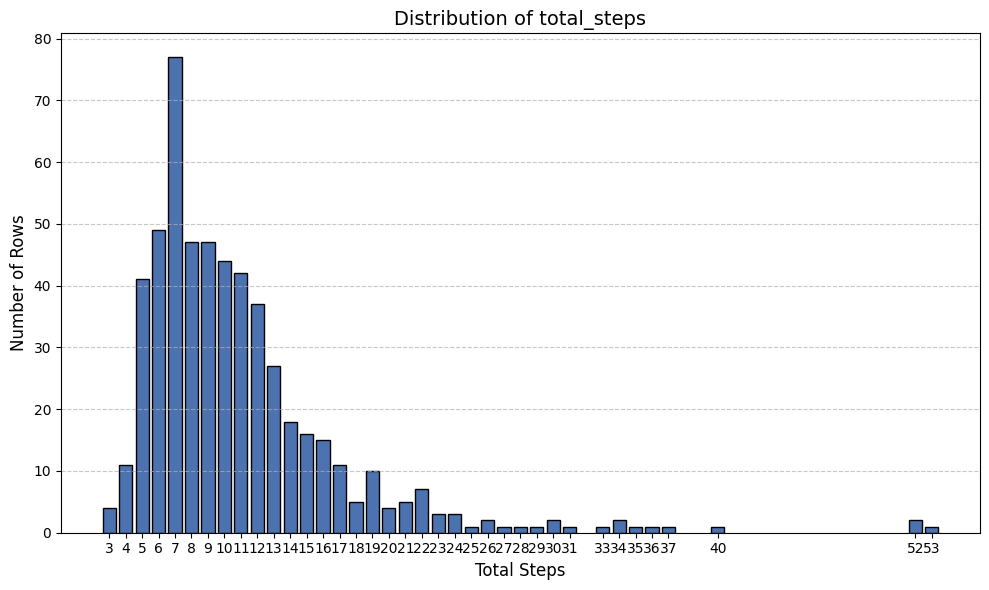

In [140]:
plot_total_steps_distribution(df_prm800k_test_feature_engineered)

### 6. Negative Steps Position Distribution

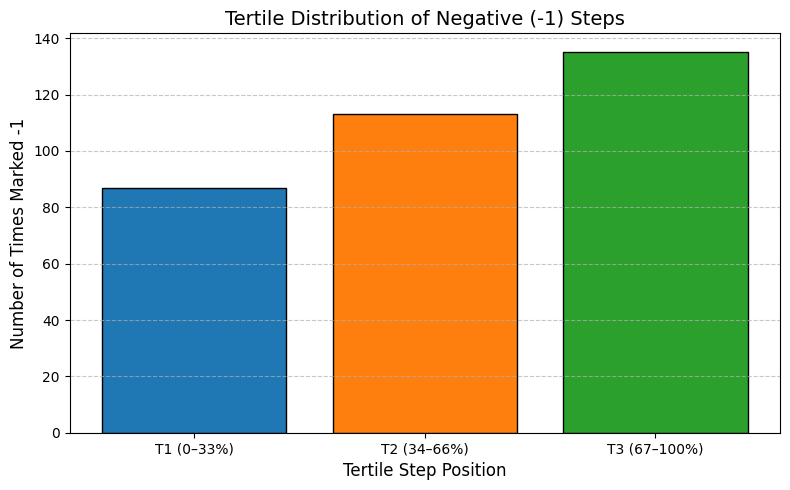

In [141]:
plot_negative_steps_tertile_distribution(df_prm800k_test_feature_engineered)

### 7. Zero Steps Position Distribution

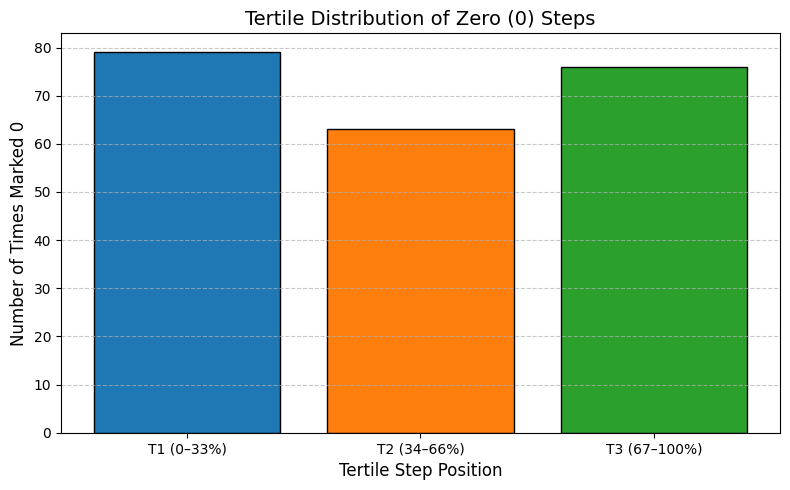

In [142]:
plot_zero_steps_tertile_distribution(df_prm800k_test_feature_engineered)